# Assignment 9
## Nisarg Kumar Panchal (ee22b125)

## Overview - Reconstructing an image using the Delay-and-Sum (DAS) algorithm that is commonly used in Ultrasound image reconstruction.

## Setting up all the required imports

In [1]:
  import io
  import numpy as np
  import matplotlib.pyplot as plt

## Setting all the parameters:
1. Nmics - Total number of microphones present on y-axis.
2. Nsamp - Total number of times sampling takes place.
3. src - Location of source
4. dist_per_samp = distance between two samples.
5. C - speed of sound
6. Obstacle - location of the obstacle

In [2]:

  Nmics = 64
  Nsamp = 200 
  src = (0, 0)
  pitch = 0.1 # Spacing between microphones should be kept low but not that low
  dist_per_samp = 0.1
  C = 2
  obstacle = (3, -1)

## PLotting Sinc Wave
### Question 1 - The plots below show two example sinc pulses. How will you generate pulses that look like this? Which parameter should be changed? What effect do you think this will have on the final image?


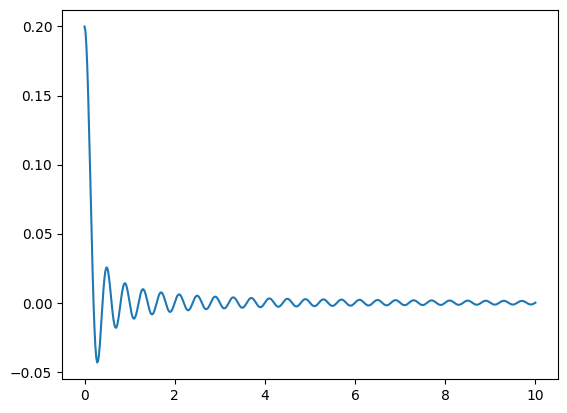

In [3]:
  def wsrc(SincP,t):
    return np.sinc(SincP*t)*0.2

  x = np.linspace(0,10,500)
  y = wsrc(5,x)

  plt.plot(x,y)
  plt.show()

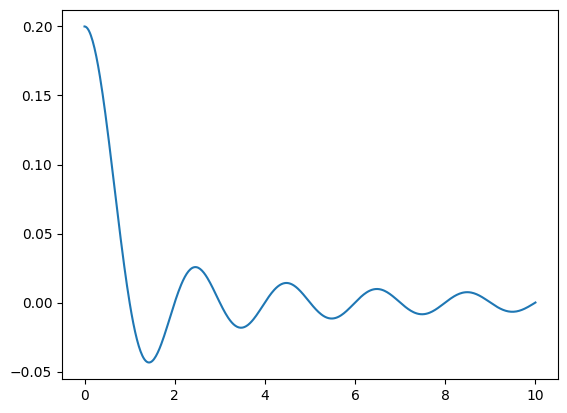

In [4]:
  x = np.linspace(0,10,500)
  y = wsrc(1,x)

  plt.plot(x,y)
  plt.show()



## Answer to Question 1
 I changed the value of SincP i.e. Time dilation to sinc function as it increases the function is squeezed about x axis therefore i reduced it to genrate images given in file.

# Distance function
### Calculates distance from source to obtacle and obstacle to mic

In [5]:
def dist(src, pt, mic):
    d1 = ((pt[0] - src[0])**2 + (pt[1] - src[1])**2 )**0.5 # CODE distance from src to pt
    d2 = ((pt[0] - mic[0])**2 + (pt[1] - mic[1])**2 )**0.5 # CODE distance from pt to mic
    return d1 + d2


## Setting up locations of each microphone.

In [15]:
  mics = []
  for i in range(Nmics):
      if Nmics % 2 == 0:
          mics.append((0, ((Nmics / 2) - i) * pitch - pitch/2))
      else:
          mics.append((0, ((Nmics // 2) - i) * pitch))

## Setting up a list T_samples containing time at which mic checks and samples any signal recieved.

In [7]:
  T_Samples = [dist_per_samp/C * i for i in range(Nsamp)]

# Setting up signals recieved by all the mics and plotting them vs Time

## Graph Plotting

- Considering mic has zero till signal reaches mic(mic cannot detect signal till mic recieves it).
- Till sound reaches mic, sound detected is 0.
- After sound reaches mic the sinc wave will be replicated.
- To find time taken to reach mic, $$t = \frac{dist(src-obstacle-mic)}{C(Speed  of sound)}$$
- Then creating a numpy array of x and y coordinates for each mic.
- y coordinate - *(+ mics[i])* for plotting graph in front of the position of mic.

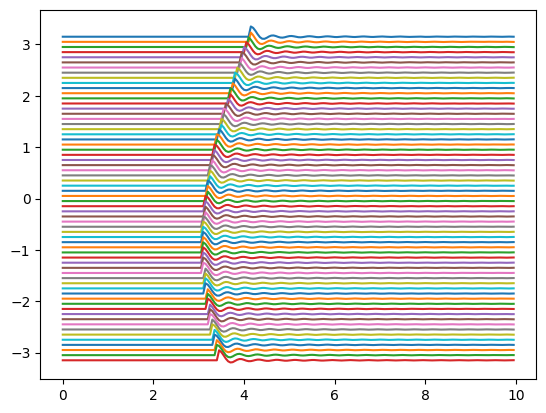

In [8]:
sincP = 5
samples_mic = []

T_Samples = [(dist_per_samp / C) * i for i in range(Nsamp)]


for i in range(Nmics):
    temp = []
    time = dist(src, obstacle, mics[i])/C
    for j in T_Samples:
        if j < time:
            temp.append(mics[i][1])
        else:
            temp.append(wsrc(5,j - time)+mics[i][1])
    samples_mic.append(temp)


for i in range(len(samples_mic)):
    plt.plot(T_Samples, samples_mic[i])

plt.show()


# Plotting a Heat map representing signals recieved by mics.

### - all_signal is a NmicsxNsamp array containing siganal recieved by each mic over the Nsamp range , it is used in reconstruction.
### - X and Y axis are set using extent

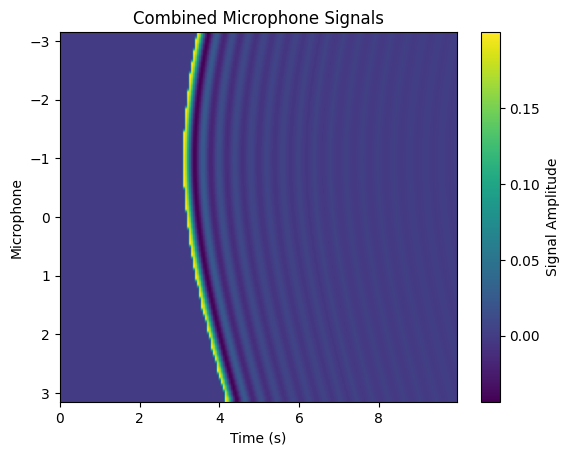

In [9]:
all_signals = np.zeros((Nmics, Nsamp))

for i in range(Nmics):
    temp = np.zeros(Nsamp)
    time = dist(src, obstacle, mics[i]) / C
    for j in range(Nsamp):
        if T_Samples[j] < time:
            continue
        else:
            temp[j] = wsrc(5,T_Samples[j] - time)
    all_signals[i, :] = temp
# print(all_signals)
# print(all_signals.shape)
# Create a heatmap of the combined microphone signals
plt.imshow(all_signals, aspect='auto', cmap='viridis', origin='lower', extent=[T_Samples[0], T_Samples[-1], mics[0][1], mics[-1][1]])

plt.colorbar(label='Signal Amplitude')
plt.title('Combined Microphone Signals')
plt.xlabel('Time (s)')
plt.ylabel('Microphone')
plt.show()


# Reconstructing using Delay-and-Sum algorithm

## Image Reconstruction

- Obstacle set at a point (x,y) - x is a time when mic samples and y is the y-coordinate of a mic.
- Checking for all points (x,y).
- Finding the sum of wave at that point for all mics.
- Creating a matrix and then heatplot.

### QUESTION - Does it make sense to reconstruct up to Nsamp? What value is more reasonable as an upper limit for the x-axis here?

### Answer -

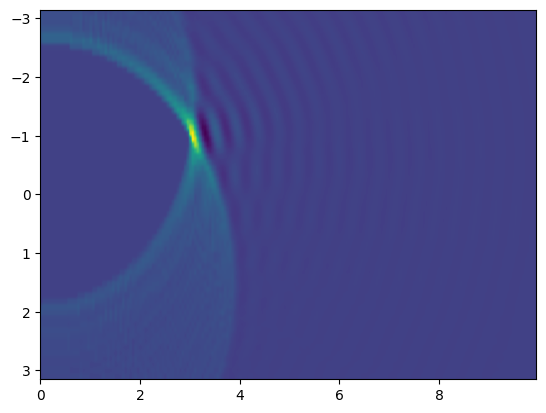

In [18]:
bestx = Nsamp
t_max = Nsamp*dist_per_samp/2
for i in range(Nsamp):
    if T_Samples[i] > t_max:
        bestx = i
        break
    
def reconstruct_signals(all_signals,Nmics,Nsamp, src, mics, T_Samples, C):
    reconstructed = np.zeros((Nmics, bestx))

    for i in range(Nmics):
        for j in range(bestx):
            for k in range(Nmics):
                time_delayk = dist(src, (T_Samples[j], mics[i][1]), mics[k]) / C
                closest_value = min(T_Samples, key=lambda x: abs(time_delayk - x))
                reconstructed[i][j] += all_signals[k][T_Samples.index(closest_value)]

    return reconstructed

reconstructed_given = reconstruct_signals(all_signals,Nmics,Nsamp, src, mics, T_Samples, C)

plt.imshow(reconstructed_given, aspect='auto', cmap='viridis', origin='lower', extent=[T_Samples[0], T_Samples[bestx-1], mics[0][1], mics[-1][1]])
plt.show()

### As it can be seen above the obstacle is present at (3,-1)

# Reading from the files given in the question and reconstructing.

In [11]:
def data(file_name):
    try:
        with open(f"{file_name}", "r") as f:
            sfp = io.StringIO(f.read())
            data = sfp.readlines()
            copy = []
            for i in data:
                temp=[]
                temp = i.split()
                for j in range(len(temp)):
                    temp[j] = float(temp[j])
                copy.append(temp)
        return copy
    except FileNotFoundError:
        raise FileNotFoundError('Please give the name of a valid file as input')
    

## Reconstructinng for file rx2

### For recontructing un-comment the cell below and upload the rx2.txt file

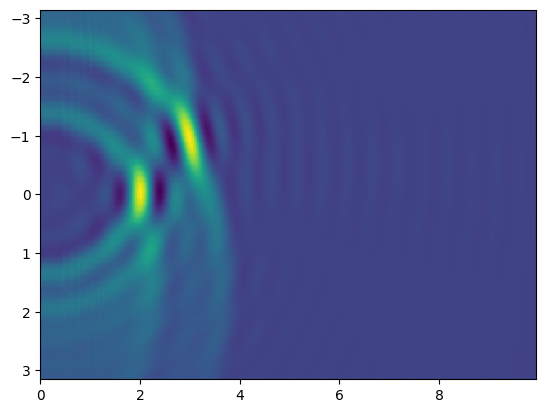

In [19]:
# reconstructed_rx2 = (data("rx2.txt"))
# reconstructed_rx2heat = reconstruct_signals(reconstructed_rx2,Nmics,Nsamp, src, mics, T_Samples, C)
# plt.imshow(reconstructed_rx2heat[::-1], aspect='auto', cmap='viridis', origin='lower', extent=[T_Samples[0], T_Samples[-1], mics[0][1], mics[-1][1]])
# plt.show()
 

### As it can be seen above the obstacles are present at (2,0) and (3,-1) . I have added this image to pdf file as well.

## Reconstructing for file rx3

### For recontructing un-comment the cell below and upload the rx3.txt file

In [13]:
# reconstructed_rx3 = (data("rx3.txt"))
# reconstructed_rx3heat = reconstruct_signals(reconstructed_rx3,Nmics,Nsamp, src, mics, T_Samples, C)
# plt.imshow(reconstructed_rx3heat[::-1], aspect='auto', cmap='viridis', origin='lower', extent=[T_Samples[0], T_Samples[-1], mics[0][1], mics[-1][1]])
# plt.show()

### As it can be seen above the obstacles are present at (2,0),(3,-1) and (4,0.5). I have added this image to pdf file as well.

## QUESTIONS

• The (x, y) coordinates corresponding to the maximum amplitude (yellow colour) is approximately(30, 22). Explain why this is the correct expected position for the given obstacle.

Answer - 30 represents the No. of sample thus 30 * .1 represents 3 in the X axis. 22 represents the 23rd mic from the bottom, thus it has the coordinate near -1 Since they have plot mics from the bottom.


• What is the maximum obstacle x- and y- coordinate that you can use and still have an image reconstructed?

Answer -  Max (X,Y) can be such that max(dist_delay) = sorce to obs + obs to Farthest mic is not greater than Nsamp*dis_per_samp (20 in this case.)
For each mic this range specifies an `Ellipse` enclosing the range.


• What happens if C is different - if C is decreased it looks like the image becomes sharper. Can you explain why intuitively?

Answer - As c is decreased the image get sharper because If C is decreased we get a larger interval of time between two samples which results in sharper higher amplitude with respect to nearby points.


• What happens if Nmics is increased or decreased? Do the experiments with Nmics = [8, 32, 64] and Nsamp = [50, 100, 200] (all combinations). Attach the resulting images.
Answer - As Nmics is increased image gets more distinguished , For Nsamp = 50 we do not get point recognised as it is out of range as explained in question 2. All images are attached in the pdf submitted along with this notebook.